In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn import metrics

import seaborn as sns
sns.set()

## 5.8 决策树与随机森林
随机森林是一种集成方法，通过集成多个比较简单的评估器形成累积效果。集成方法的学习效果往往能超过各个组成部分的总和；也就是说，若干评估器的多数投票的最终效果往往优于单个评估器投票的效果。

### 5.8.1 随机森林的诱因：决策树
随机森林是建立在决策树基础上的集成学习器。

决策树采用非常直观的方式对事物进行分类或打标签。例如，建一棵决策树来判断旅行时遇到的一只动物的种类(`图5-67`)：
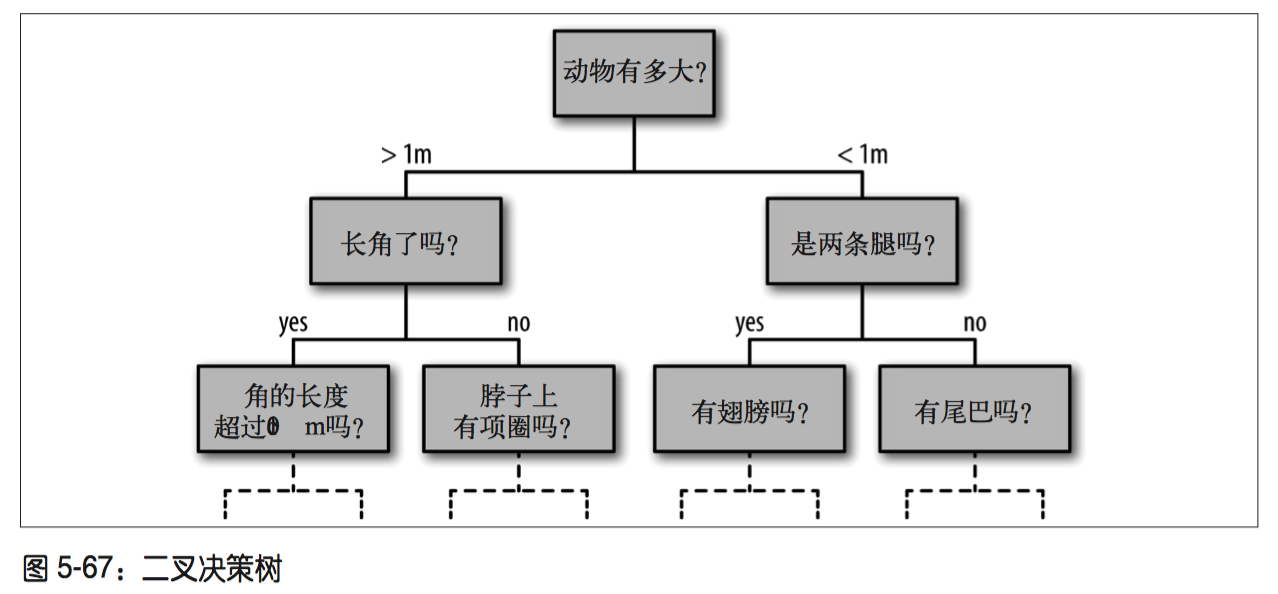

二叉树分支方法可以非常有效地进行分类：在一棵结构合理的决策树中，每个问题基本上都可将种类可能性减半；即使是对大量种类进行决策时，也可以很快地缩小选择范围。决策树的难点在于如何设计每一步的问题。在实现决策树的机器学习算法中，问题通常因分类边界是与特征轴平行的形式分割数据而造成的；也就是说，决策树的每个节点都根据一个特征的阈值将数据分成两组。

#### 5.8.1.1 创建一棵决策树
下面的二维数据共有四种标签(`图5-68`)：

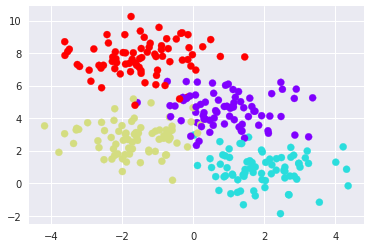

In [2]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0) 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

在这组数据上构建的简单决策树不断将特征按照某种判定条件进行分割。每分割一次，都将新区域内点的多数投票结果标签分配到该区域上。`图5-69`展示前四次分割的可视化结果：
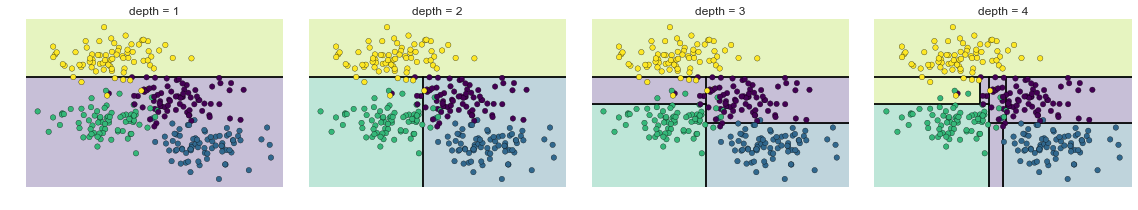

需要注意的是，第一次分割之后，上半个分支里的所有数据点都没有变化，因此这个分支不需要继续分割。除非一个节点只包含一种颜色，那么每次分割都需要按照两种特征中的一种对每个区域进行分割。

我们使用`Scikit-Learn`的`DecisionTreeClassifier`评估器拟合数据：

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


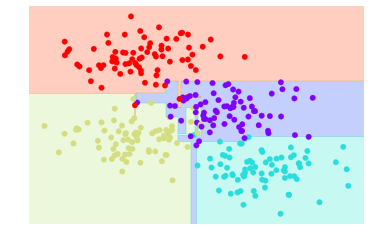

In [3]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

tree = DecisionTreeClassifier().fit(X, y)
visualize_classifier(DecisionTreeClassifier(), X, y)
plt.show()

请注意，随着决策树深度的不断增加，我们可能会看到形状非常奇怪的分类区域。例如，在深度为5的时候，在黄色与蓝色区域中间有一个狭长的浅紫色区域。这显然不是根据数据本身的分布情况生成的正确分类结果，而更像是一个特殊的数据样本或数据噪音形成的干扰结果。也就是说，这棵决策树刚刚分到第5层，数据就出现了过拟合。

#### 5.8.1.2 决策树与过拟合
这种过拟合正是决策树的一般属性，决策树非常容易陷得很深，因此往往会拟合局部数据，缺少对整个数据分布的大局观。换个角度看这种过拟合，可以认为模型训练的是数据的不同子集。例如，在`图5-72`中我们训练了两棵不同的决策树，每棵树拟合一半数据：
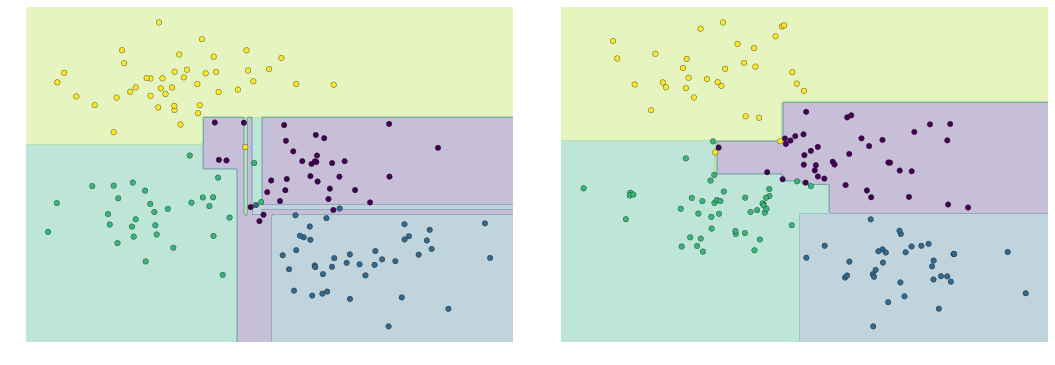

在一些区域，例如4个角上，两棵树产生了一致的结果；在另一些区域，两棵树的分类结果差异很大。不一致往往都发生在分类比较模糊的地方，因此假如将两棵树的结果组合起来，可能就会获得更好的结果(`图5-73`)：
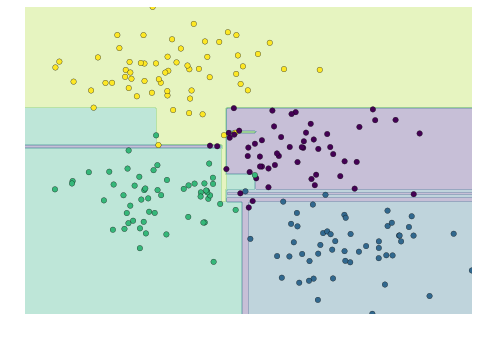

### 5.8.2 评估器集成算法：随机森林
组合多个过拟合评估器来降低过拟合程度的想法是一种集成学习方法，称为`装袋算法`。装袋算法使用并行评估器对数据进行有放回抽取集成，每个评估器都对数据过拟合，通过求均值获得更好的分类结果。随机决策树的集成算法就是`随机森林`。

`Scikit-Learn`的`BaggingClassifier`元评估器可以实现这种`装袋分类器`(`图5-74`)：

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


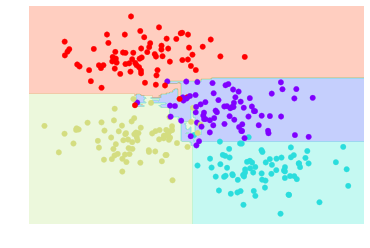

In [4]:
tree = DecisionTreeClassifier() 
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
visualize_classifier(bag, X, y)
plt.show()

每个评估器拟合样本`80%`的随机数。如果我们用`随机方法`(stochasticity)确定数据的分割方式，决策树拟合的随机性会更有效；这样做可以让所有数据在每次训练时都被拟合，但拟合的结果却仍然是随机的。例如，当需要确定对哪个特征进行分割时，随机树可能会从最前面的几个特征中挑选。关于随机策略选择的更多技术细节，参考[Scikit-Learn文档](http://scikit-learn.org/stable/modules/ensemble.html#forest)。

`Scikit-Learn`对随机决策树集成算法的优化是通过`RandomForestClassifier`评估器实现的，它会自动进行随机化决策。你只要选择一组评估器， 它们就可以非常快速地完成每棵树的拟合任务(`图5-75`)：

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


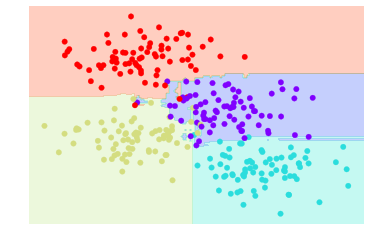

In [5]:
model = RandomForestClassifier(n_estimators=100, random_state=0) 
visualize_classifier(model, X, y)
plt.show()

从图中可以看出，如果使用`100`棵随机决策树，就可以得到一个非常接近我们直觉的`关于数据空间应该如何分割`的整体模型。

### 5.8.3 随机森林回归
随机森林也可以用作回归，随机森林回归的评估器是`RandomForestRegressor`。

下面的数据通过快慢振荡组合而成(`图5-76`)：

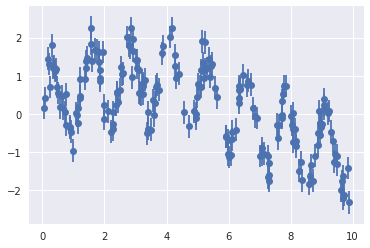

In [6]:
rng = np.random.RandomState(42)

x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x) 
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x) 
plt.errorbar(x, y, 0.3, fmt='o')
plt.show()

使用随机森林回归器获得如下拟合曲线(`图5-77`)：

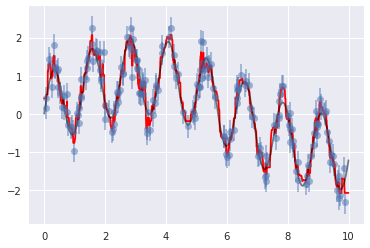

In [7]:
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000) 
yfit = forest.predict(xfit[:, None]) 
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5) 
plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-k', alpha=0.5)
plt.show()

真实模型是平滑曲线，而随机森林模型是锯齿线。从图中可以看出，无参数的随机森林模型非常适合处理多周期数据，不需要我们配置多周期模型！

### 5.8.4 案例：用随机森林识别手写数字
我们使用随机森林分类器识别手写数字数据集：

In [8]:
digits = load_digits()
digits.keys()

dict_keys(['target_names', 'DESCR', 'images', 'target', 'data'])

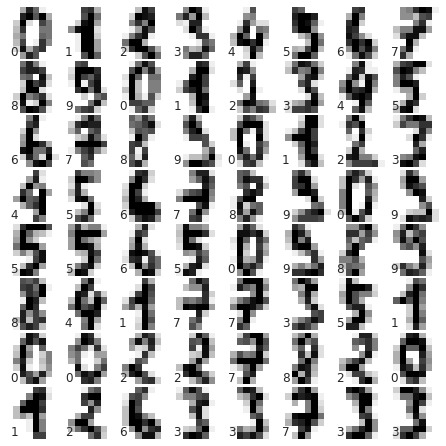

In [9]:
# 设置图形对象
fig = plt.figure(figsize=(6, 6))

# 以英寸为单位 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 画数字：每个数字是8像素×8像素 
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # 用target值给图像作标注 
    ax.text(0, 7, str(digits.target[i]))

plt.show()

用随机森林快速对数字进行分类(`图5-79`)：

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0) 

model = RandomForestClassifier(n_estimators=1000) 
model.fit(Xtrain, ytrain) 
ypred = model.predict(Xtest)

# 分类结果报告
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       0.98      0.98      0.98        43
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.96      0.98      0.97        47
          9       0.98      0.98      0.98        47

avg / total       0.98      0.98      0.98       450



画出混淆矩阵(`图5-79`)：

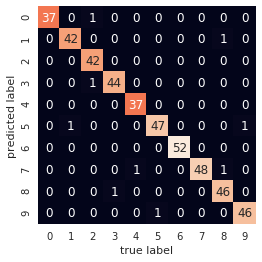

In [11]:
mat = confusion_matrix(ytest, ypred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true label') 
plt.ylabel('predicted label')
plt.show()

一个简单、未调优的随机森林就可以取得非常好的分类准确率。

### 5.8.5 随机森林总结
随机森林是一种强大的机器学习方法，它的优势在于：
+ 决策树的原理很简单，因此它的训练和预测速度都非常快
+ 因为每棵树都是完全独立的，任务可以直接并行计算
+ 多棵树可以进行概率分类：多个评估器之间的多数投票可以给出概率的估计值(使用`Scikit-Learn`的`predict_proba()`方法)
+ 无参数模型很灵活，在其他评估器都欠拟合的任务中表现突出

随机森林的主要缺点在于其结果不太容易解释，如果你想要总结分类模型的意义，随机森林可能不是最佳选择。